# <span style="color:cornflowerblue"><center> Numerical Simulation Laboratory</center></span>
## <span style="color:cornflowerblue"><center> Samuele Brambilla - Notebook 12</center></span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [20]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [21]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


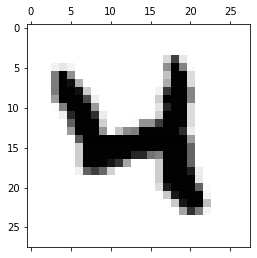

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [22]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Example: to_categorical

In [23]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [25]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [26]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7280 - acc: 0.7886 - val_loss: 0.3028 - val_acc: 0.9178
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3727 - acc: 0.8941 - val_loss: 0.2340 - val_acc: 0.9324
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3016 - acc: 0.9159 - val_loss: 0.1968 - val_acc: 0.9422
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2597 - acc: 0.9276 - val_loss: 0.1723 - val_acc: 0.9477
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2301 - acc: 0.9352 - val_loss: 0.1573 - val_acc: 0.9497


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 1s 2ms/step - loss: 0.1573 - acc: 0.9497

Test loss: 0.1573047786951065
Test accuracy: 0.9496999979019165


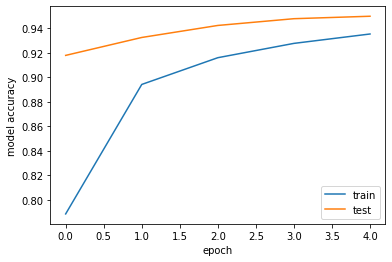

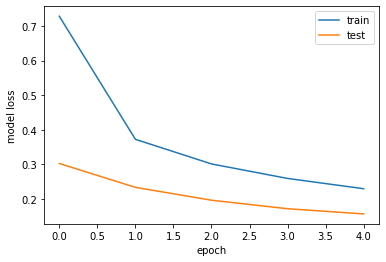

In [27]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

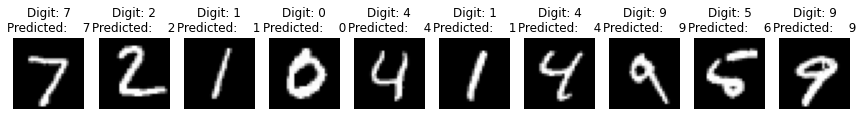

In [28]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

# Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

In [29]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

## ADAM optimizer

L'ottimizzatore è u metodo di stocastic gradient descent che aggiorna i learning rate di diversi parametri utilizzando una media mobile pesata del primo e del secondo momento del gradiente dove il peso decade esponenzialmente con la distanza tra il punto attuale e dove si è considerato l'i-esimo gradiente. Un semplice SGD, invece, utilizza lo stesso step (learning rate) per tutti i parametri della rete.

L'utilizzo del primo e secondo momento del gradiente consente ad Adam di essere localmente più stabile di una semplice SGD vicino a minimi acuti. 

Adam è costruito partendo da AdaGrad* e RMSprop ed è adatto a problemi con un ampio numero di parametri o dati. Al momento è l'ottimizzatore più usato.

*: AdaGrad performa step di size diverse in base alla frequenza di utilizzo dei parametri: a quelli meno usati AdaGrad impone un learning rate (step size) maggiore. Ogni learning rate viene diviso per la norma $l^2$ della somma di tutti i gradienti precedenti così che parametri meno usati siano divisi per una norma minore. Per questo AdaGrad è utilizzato in problemi con sparse data.

In [30]:
from tensorflow.keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
num_classes = 10 # 10 digits - output
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
#Y contiene le etichette corrette

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) #ora sono (60000, 784)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)


batch_size = 32
epochs = 10

In [31]:
model1 = create_DNN()
model1.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer = Adam(),
                  metrics=['accuracy'])

In [32]:
history = model1.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2823 - accuracy: 0.9174 - val_loss: 0.1169 - val_accuracy: 0.9638
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1241 - accuracy: 0.9638 - val_loss: 0.0922 - val_accuracy: 0.9714
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0889 - accuracy: 0.9746 - val_loss: 0.0757 - val_accuracy: 0.9767
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0695 - accuracy: 0.9795 - val_loss: 0.0797 - val_accuracy: 0.9748
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0577 - accuracy: 0.9827 - val_loss: 0.0749 - val_accuracy: 0.9791
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0465 - accuracy: 0.9858 - val_loss: 0.0828 - val_accuracy: 0.9791
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0429 - accuracy: 0.9869 - val_loss: 0.0878 - val_accuracy:

313/313 [==============================] - 1s 2ms/step - loss: 0.0929 - accuracy: 0.9804

Test loss: 0.09286075085401535
Test accuracy: 0.980400025844574


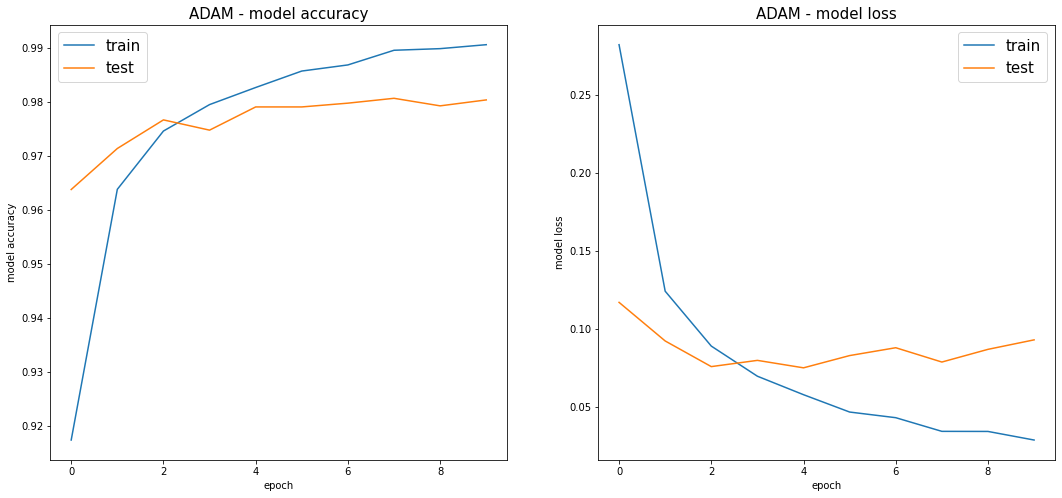

In [33]:
# evaluate model
score = model1.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
fig , ax = plt.subplots( 1 , 2 , figsize=(18 , 8))
# summarize history for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_title('ADAM - model accuracy', fontsize = 15)
ax[0].legend(['train', 'test'], loc='best', prop={'size':15})

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_title('ADAM - model loss', fontsize = 15)
ax[1].legend(['train', 'test'], loc='best', prop={'size':15})

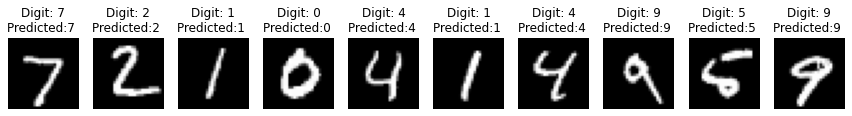

In [34]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model1.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15))
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{} ".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

## NADAM optimizer

Nadam è un ottimizzatore costruito come estensione di Adam ma che utilizza il momento di Nesterov, Nadam è quindi una Nesterov accelerated RMSprop. Semplificando la funzionamento, Il momento di Nesterov approssima la successiva posizione dei parametri così da correggere la mossa presente in modo tale che non sia troppo influenzata dal peso dei gradienti precedenti.

L'utilizzo di un momento di Nesterov permette a Nadam di convergere più velocemente di Adam in alcuni casi: per come è costruito il peso del primo e secondo momento del gradiente in Adam è possibile, infatti, che lo step size (learning rate) dei parametri diminuisca velocemente per a piccoli valori.

Questo non fa di Nadam un algoritmo migliore di Adam (come quest'ultimo non è migliore della semplice SGD): ogni ottimizzatore può essere migliore di un altro in una determinata applicazione ma non è intrinsecamente migliore di un altro (richiamiamo così, in maniera lata,  il "no free lunch theorem").

In [35]:
from tensorflow.keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
num_classes = 10 # 10 digits as output
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
#Y contiene le etichette corrette

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) #ora sono (60000, 784)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)


batch_size = 32
epochs = 10

In [36]:
model2 = create_DNN()
model2.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer = Nadam(),
                  metrics=['accuracy'])

In [37]:
history = model2.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2764 - accuracy: 0.9197 - val_loss: 0.1017 - val_accuracy: 0.9688
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1196 - accuracy: 0.9651 - val_loss: 0.0885 - val_accuracy: 0.9728
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0860 - accuracy: 0.9745 - val_loss: 0.0789 - val_accuracy: 0.9762
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0677 - accuracy: 0.9798 - val_loss: 0.0730 - val_accuracy: 0.9790
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0585 - accuracy: 0.9823 - val_loss: 0.0668 - val_accuracy: 0.9811
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0467 - accuracy: 0.9855 - val_loss: 0.0805 - val_accuracy: 0.9793
Epoch 7/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0421 - accuracy: 0.9872 - val_loss: 0.0898 - val_accuracy:

313/313 [==============================] - 1s 2ms/step - loss: 0.0820 - accuracy: 0.9832

Test loss: 0.08198201656341553
Test accuracy: 0.9832000136375427


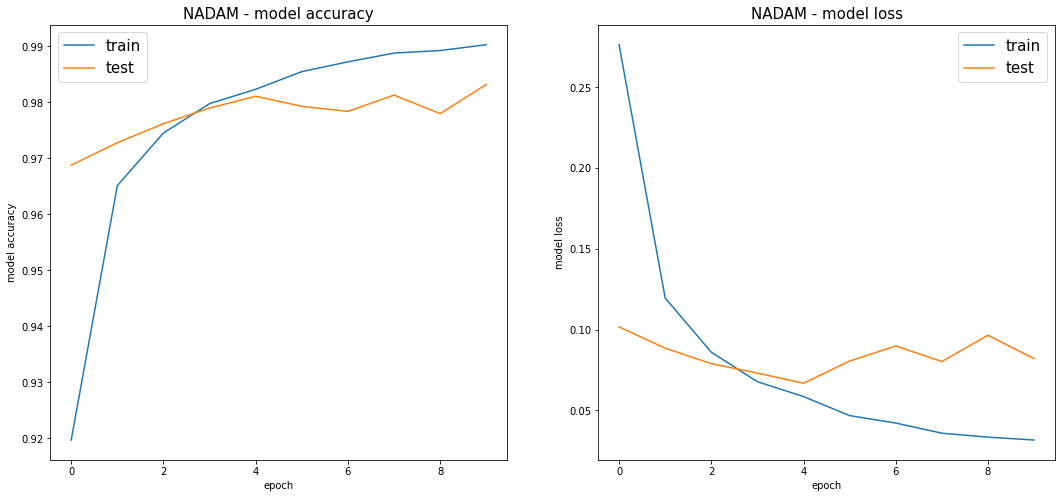

In [38]:
# evaluate model
score = model2.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
fig , ax = plt.subplots( 1 , 2 , figsize=(18 , 8))
# summarize history for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_title('NADAM - model accuracy', fontsize = 15)
ax[0].legend(['train', 'test'], loc='best', prop={'size':15})

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_title('NADAM - model loss', fontsize = 15)
ax[1].legend(['train', 'test'], loc='best', prop={'size':15})

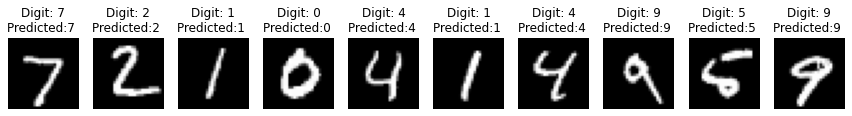

In [39]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model2.predict(X_test)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{} ".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

## ADAMAX optimizer

Adamax è un'estensione di Adam basata sulla nomra $l^∞$. Rispetto alle norme $l^p$, infatti, la norma $l^∞$ mantiene un comportamento numericamente stabile, così come le norme $l^1$ e $l^2$.

Adamax è specialmente buono per modelli con embedding.

In [40]:
from tensorflow.keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
num_classes = 10 # 10 digits as output
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
#Y contiene le etichette corrette

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) #ora sono (60000, 784)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)


batch_size = 32
epochs = 10

In [41]:
model3 = create_DNN()
model3.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer = Adamax(),
                  metrics=['accuracy'])

In [42]:
history = model3.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4072 - accuracy: 0.8825 - val_loss: 0.1702 - val_accuracy: 0.9496
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1980 - accuracy: 0.9439 - val_loss: 0.1204 - val_accuracy: 0.9634
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1471 - accuracy: 0.9583 - val_loss: 0.0953 - val_accuracy: 0.9707
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1166 - accuracy: 0.9671 - val_loss: 0.0849 - val_accuracy: 0.9732
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0968 - accuracy: 0.9719 - val_loss: 0.0758 - val_accuracy: 0.9766
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0829 - accuracy: 0.9760 - val_loss: 0.0724 - val_accuracy: 0.9771
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0718 - accuracy: 0.9802 - val_loss: 0.0689 - val_accuracy:

313/313 [==============================] - 1s 2ms/step - loss: 0.0624 - accuracy: 0.9800

Test loss: 0.06238028407096863
Test accuracy: 0.9800000190734863


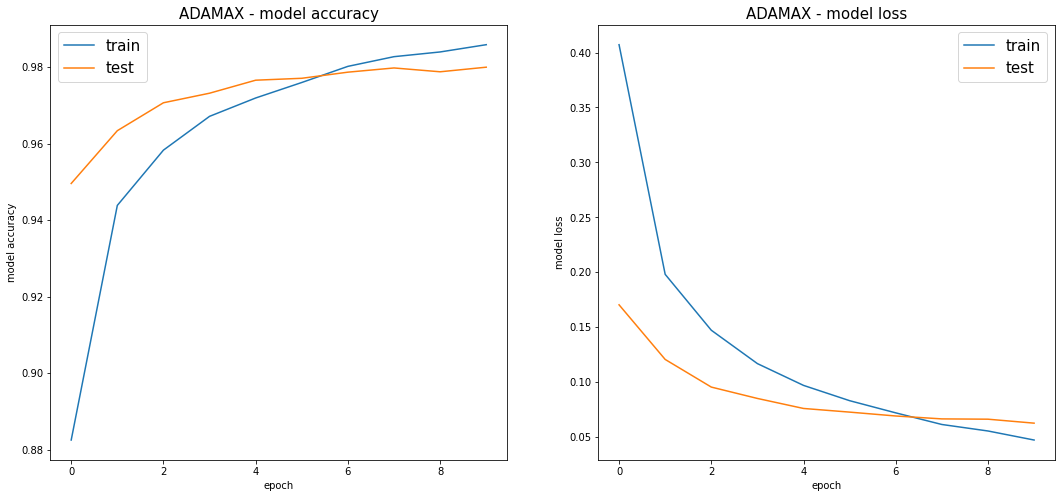

In [43]:
# evaluate model
score = model3.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
fig , ax = plt.subplots( 1 , 2 , figsize=(18 , 8))
# summarize history for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_title('ADAMAX - model accuracy', fontsize = 15)
ax[0].legend(['train', 'test'], loc='best', prop={'size':15})

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_title('ADAMAX - model loss', fontsize = 15)
ax[1].legend(['train', 'test'], loc='best', prop={'size':15})

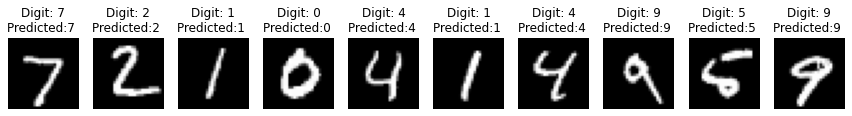

In [44]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model3.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{} ".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

## RMSprop optimizer

RMSprop e Adadelta sono due ottimizzatori molto simili creati in maniera indipendente per ovviare alla monotona diminuzione dei learning rate di AdaGrad.

RMSprop accumula la norma $L^2$ di tutti i gradienti passati ma ogni norma è pesata dall'esponenziale decrescente della media delle norme $L^2$ dei gradienti passati.

AdaDelta, invece, non accumula tutti i gradienti quadri degli step passati, solamente quelli entro una certa finestra.

In [45]:
from tensorflow.keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
num_classes = 10 # 10 digits as output
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
#Y contiene le etichette corrette

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) #ora sono (60000, 784)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)


batch_size = 32
epochs = 5

In [46]:
model4 = create_DNN()
model4.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer = RMSprop(),
                  metrics=['accuracy'])

In [47]:
history = model4.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test), shuffle=True)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2740 - accuracy: 0.9205 - val_loss: 0.1356 - val_accuracy: 0.9646
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1499 - accuracy: 0.9628 - val_loss: 0.1233 - val_accuracy: 0.9700
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1355 - accuracy: 0.9693 - val_loss: 0.1250 - val_accuracy: 0.9726
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1390 - accuracy: 0.9717 - val_loss: 0.1509 - val_accuracy: 0.9731
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1362 - accuracy: 0.9719 - val_loss: 0.1662 - val_accuracy: 0.9736


313/313 [==============================] - 1s 2ms/step - loss: 0.1662 - accuracy: 0.9736

Test loss: 0.166230246424675
Test accuracy: 0.9735999703407288


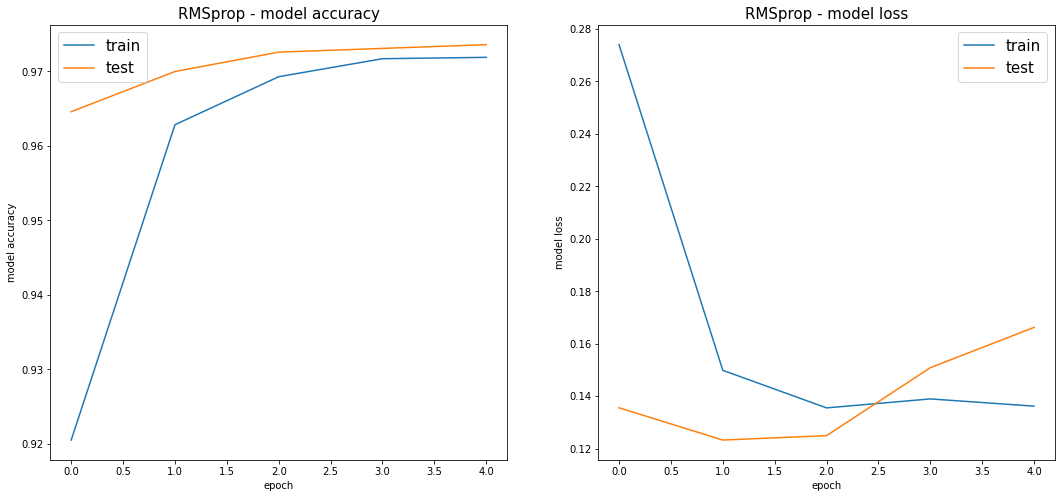

In [48]:
# evaluate model
score = model4.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
fig , ax = plt.subplots( 1 , 2 , figsize=(18 , 8))
# summarize history for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_title('RMSprop - model accuracy', fontsize = 15)
ax[0].legend(['train', 'test'], loc='best', prop={'size':15})

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_title('RMSprop - model loss', fontsize = 15)
ax[1].legend(['train', 'test'], loc='best', prop={'size':15})

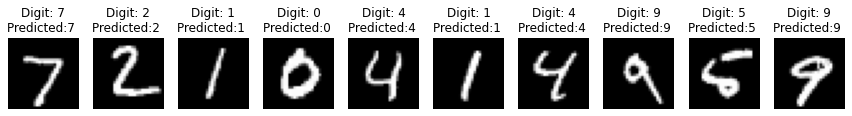

In [49]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model4.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{} ".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

## Summary
Tra le DNN create, la migliore risulta essere AdaMax (loss: 0.06 ; accuracy: 98,1%), seguita da Adam (loss: 0.09 ; accuracy: 98,0%), AdaDelta (loss: 0.1 ; accuracy: 97,8%) e infine RMSprop (loss: 0.15 ; accuracy: 97,3%). Tutti i modelli riescono a predire tutte le cifre.

RMSprop è stata allenata con un numero minore di epoche rispetto alle altre così che la rete non facesse overfitting sui dati (cosa che si osserva facilmente con già 7 epoche e che si confermaq con 10, dove la funzione loss arriva ad un valore di 0.2)

## Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [50]:
from tensorflow.keras.datasets import mnist
img_rows, img_cols = 28, 28 # number of pixels 
num_classes = 10 # 10 digits as output
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) #ora sono (60000, 784)
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [51]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D, UpSampling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

# Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that you should complete:

In [52]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 32 filters (dimensionality of output space)
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    
    #small autoencoder
    model.add( MaxPooling2D( pool_size=(2,2), padding='same') ) #add same padding pixels in every dim
    model.add( Conv2D(5, kernel_size=(3, 3), activation='relu') )
    model.add( UpSampling2D( (2,2)) )
    model.add( Dropout(0.5) )
    model.add( Flatten() )
    model.add( Dense(100, activation="sigmoid") )
    model.add( Dense(10 , activation="softmax") )
    
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [53]:
# training parameters
batch_size = 32
epochs = 20
# create the deep conv net
model_CNN=create_CNN()
# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)
# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1875/1875 [==============================] - 18s 5ms/step - loss: 0.2187 - accuracy: 0.9401 - val_loss: 0.0707 - val_accuracy: 0.9794
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0823 - accuracy: 0.9752 - val_loss: 0.0543 - val_accuracy: 0.9836
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0624 - accuracy: 0.9811 - val_loss: 0.0466 - val_accuracy: 0.9850
Epoch 4/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0526 - accuracy: 0.9839 - val_loss: 0.0428 - val_accuracy: 0.9849
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0460 - accuracy: 0.9859 - val_loss: 0.0391 - val_accuracy: 0.9872
Epoch 6/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.0351 - val_accuracy: 0.9887
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0367 - accuracy: 0.9888 - val_loss: 0.0321 - val_accuracy

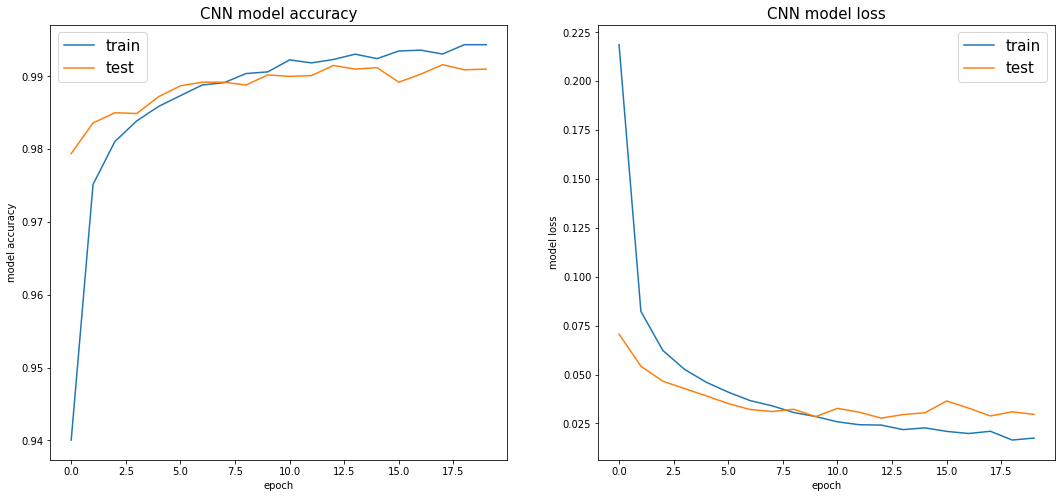

In [54]:
 # look into training history
fig , ax = plt.subplots( 1 , 2 , figsize=(18 , 8))
# summarize history for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_title('CNN model accuracy', fontsize = 15)
ax[0].legend(['train', 'test'], loc='best', prop={'size':15})

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_title('CNN model loss', fontsize = 15)
ax[1].legend(['train', 'test'], loc='best', prop={'size':15})

CNN loss: 0.029616082087159157
CNN accuracy: 0.9909999966621399


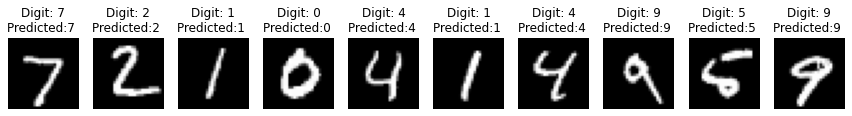

In [55]:
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

print('CNN loss:', score[0])
print('CNN accuracy:', score[1])

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{} ".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Ho costruito la Convolution Neural Network sul modello di un autoencoder. Un autoencoder è, semplificandone la definizione, un unsupervised neural network che impara come ridurre i dati e come ricostruire dai dati compressi una rappresentazione il più simile possibile all'input originale: in questo modo l'autoencoder riduce le dimensioni dei dati imparando a ignorare il rumore nei dati stessi.
La rete è quindi costruita nel modo seguente:
- layer di convoluzione iniziale con attivazione relu;
- un layer di max pooling che dimezza le dimensioni dell'immagine;
- layer di convoluzione sui dati ridotti con attivazione relu;
- layer di upsampling che riporta l'immagine alle dimensioni originali ripetendo le righe due volte;
- chiamata delle funzioni Dropout e Flatten per impedire overfitting e riscrivere i dati in riga (il Dropout viene ignorato sui dati di test così da migliorare la predizione);
- layer denso da 100 neuroni con attivazione sigmoide;
- layer di output finale softmax così che l'output siano delle probabilità;

La CNN costruita raggiunge un'accuratezza del 99%, superiore a quelle delle Deep Neural Network costruite e riesce a identificare tutte le cifre di test.

# Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

In [10]:
# TO LOAD FILES ON GOOGLE COLAB
from google.colab import files
upload = files.upload() #this will let you browse and choose the file to be uploaded

Saving digit_7.png to digit_7.png


Image size: 28x28


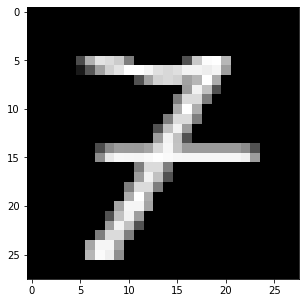

(28, 28)


In [56]:
from PIL import Image
import os

digit_filename = "digit_7.png"
digit_in = Image.open(digit_filename).convert('L')
#digit_in = Image.open("8b.png").convert('L') #ON GOOGLE COLAB INSERT THE NAME OF THE UPLOADED FILE

ydim, xdim = digit_in.size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix=digit_in.load();
data = np.zeros((xdim, ydim))
for j in range(ydim):
    for i in range(xdim):
        data[i,j]=pix[j,i]

data /= 255

plt.figure(figsize=(5,5))
plt.imshow(data, cmap='gray')
plt.show()

print(data.shape)

### DNN prediction

(28, 28)
(1, 784)


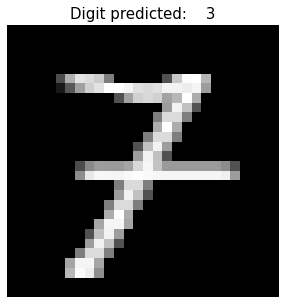

In [57]:
print(data.shape)
data = data.reshape(1,xdim*ydim)
print(data.shape)
pred_0 = model_DNN.predict(data)

data = data.reshape(xdim,ydim)

plt.figure(figsize=(5, 5))  
plt.imshow(data, cmap='gray')    
plt.title("Digit predicted:    {}".format(np.argmax(pred_0)), fontsize=15)
plt.axis('off') 
plt.show()

### CNN prediction

(28, 28)
(1, 28, 28, 1)


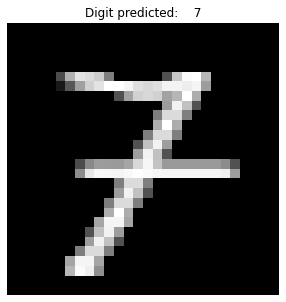

In [58]:
print(data.shape)
data = data.reshape(1,xdim,ydim,1)
print(data.shape)
pred_0 = model_CNN.predict(data)

data = data.reshape(xdim,ydim)

plt.figure(figsize=(5, 5))  
plt.imshow(data, cmap='gray')    
plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
plt.axis('off') 
plt.show()

La rete convoluzione riesce a predire correttemente tutte le 10 cifre scritte mentre la DNN ne predice correttamente solo 5.
Un risultato simile era atteso in quanto l'accuratezza raggiunta dalla rete deep è sempre inferiore a quella della rete neurale che si rivela essere una struttura più adatta per problemi di classificazione.

# Supplementary material

### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rascale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [ ]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

Display your filters:

In [ ]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

### <span style="color:green">Supplementary information 3: Monitor layer outputs in your CNN</span>

In [ ]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, layer_index): 
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [ ]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer